In [1]:
import numpy as np
import glob, os
import xarray as xr
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import copy
%matplotlib inline

In [2]:
xr.set_options(display_style='text')

In [3]:
year = '2019'
month = '01'

datadir = f'/global/cscratch1/sd/feng045/waccem/mcs_region/asia/mcstracking_ccs4_4h/{year}0101_{year}1231/'
datafiles = []
dates = np.arange(21, 22, 1)
for idate in range(0, len(dates)):
#     print(f'{dates[idate]:02}')
    datafiles.extend(sorted(glob.glob(f'{datadir}mcstrack_{year}{month}{dates[idate]:02}*.nc')))
print(f'Number of files: {len(datafiles)}')
    
date_range = f'{os.path.basename(datafiles[0])[9:17]}_{os.path.basename(datafiles[-1])[9:17]}'
figdir = f'{datadir}quicklooks/{date_range}/'
os.makedirs(f'{figdir}', exist_ok=True)
print(figdir)

Number of files: 24
/global/cscratch1/sd/feng045/waccem/mcs_region/asia/mcstracking_ccs4_4h/20190101_20191231/quicklooks/20190121_20190121/


In [4]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=256):
    """ Truncate colormap.
    """
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [5]:
# Read data
ds = xr.open_mfdataset(datafiles, concat_dim='time', combine='nested', drop_variables=['longitude','latitude','cloudnumber','pcptracknumber','numclouds'])
ds.load()

<xarray.Dataset>
Dimensions:           (lat: 1200, lon: 1450, time: 24)
Coordinates:
  * time              (time) datetime64[ns] 2019-01-21T00:30:00.000013312 ......
  * lon               (lon) float32 35.05 35.15 35.25 ... 179.8 179.9 179.9
  * lat               (lat) float32 -59.95 -59.85 -59.75 ... 59.75 59.85 59.95
Data variables:
    base_time         (time) datetime64[ns] 2019-01-21T00:30:00.000013312 ......
    julian_day        (time) float64 2.459e+06 2.459e+06 ... 2.459e+06 2.459e+06
    tb                (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    precipitation     (time, lat, lon) float32 0.07155 0.005 ... 0.02309 0.02396
    cloudtracknumber  (time, lat, lon) float64 nan nan nan nan ... nan nan nan
Attributes:
    title:       Robust MCS pixel-level tracking final output data
    comment1:    cloudtracknumber labels all cold cloud pixels identified as ...
    comment2:    tb, precipitation are full fields, use cloudtracknumber, pcp...
    startdate:   20190101
    enddate:     20191231
    contact:     Zhe Feng: zhe.feng@pnnl.gov
    created_on:  Thu Aug 20 11:14:51 2020

In [6]:
lon = ds.lon
lat = ds.lat
# lonmin = lon.min().values
# lonmax = lon.max().values
# latmin = lat.min().values
# latmax = lat.max().values
# print(lonmin, lonmax, latmin, latmax)
ntimes = ds.dims['time']

In [7]:
lonmin, lonmax, latmin, latmax = 75, 165, -15, 15
print(lonmin, lonmax, latmin, latmax)

75 165 -15 15


In [8]:
def plot_map_2panels(dataarray, levels, cmaps, titles, cblabels, cbticks, timestr, figname):
    
    mpl.rcParams['font.size'] = 12
    mpl.rcParams['font.family'] = 'Helvetica'

    map_extend = [np.round(lonmin), np.round(lonmax), np.round(latmin), np.round(latmax)]
    lonvals = mpl.ticker.FixedLocator(np.arange(-180,180.1,20))
    latvals = mpl.ticker.FixedLocator(np.arange(-90,90.1,5))
    lonv = np.arange(lonmin,lonmax+0.1,20)
    latv = np.arange(latmin,latmax+0.1,5)
    proj = ccrs.PlateCarree()
    levelshgt = [1000,2000]

    fig = plt.figure(figsize=[10,8], dpi=100)

    resolution = '50m'
    land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
    ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
    borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)
#     states = cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lakes', resolution)

    gs = gridspec.GridSpec(2,2, height_ratios=[0.4,0.4], width_ratios=[1,0.02])
    gs.update(left=0.05, right=0.95, bottom=0.1, top=0.9, wspace=0.05, hspace=0.2)
    
    fig.text(0.5, 0.94, timestr, fontsize=14, ha='center')

    # Tb Panel
    ax1 = plt.subplot(gs[0,0], projection=proj)
    ax1.set_extent(map_extend, crs=proj)
    ax1.add_feature(land, facecolor='lightgray')
#     ax1.add_feature(ocean, edgecolor='k', facecolor=cfeature.COLORS['water'])
#     ax1.add_feature(borders, edgecolor='k', facecolor='none', linewidth=1, zorder=4)
    ax1.add_feature(land, facecolor='none', edgecolor='k', lw=1.5, zorder=2)
    ax1.set_aspect('auto', adjustable=None)
    ax1.set_title(titles[0], loc='left')
    gl = ax1.gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0.5, zorder=2)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlocator = lonvals
    gl.ylocator = latvals
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    # gl = ax1.gridlines(crs=proj, draw_labels=False, linestyle='--', linewidth=0.5, zorder=2)
    # gl.xlocator = mpl.ticker.FixedLocator(lonv)
    # gl.ylocator = mpl.ticker.FixedLocator(latv)
    # ax1.set_xticks(lonv, crs=proj)
    # ax1.set_yticks(latv, crs=proj)
    # lon_formatter = LongitudeFormatter(zero_direction_label=True)
    # lat_formatter = LatitudeFormatter()
    # ax1.xaxis.set_major_formatter(lon_formatter)
    # ax1.yaxis.set_major_formatter(lat_formatter)

    cmap = copy.copy(plt.get_cmap(cmaps[0]))
    norm = mpl.colors.BoundaryNorm(levels[0], ncolors=cmap.N, clip=True)
    data = dataarray[0]
    Zm = np.ma.masked_where((np.isnan(data)), data)
    cf1 = ax1.pcolormesh(lon, lat, Zm, norm=norm, cmap=cmap, shading='auto', transform=proj, zorder=2)
    # Overplot cloudtracknumber boundary
    tn = np.copy(dataarr[2].data)
    # Replace all valid cloudtracknumber with a constant, and invalid cloudtracknumber with 0
    tn[(tn >= 1)] = 10
    tn[np.isnan(tn)] = 0
    # Overlay boundary of cloudtracknumber on Tb
    tn1 = ax1.contour(lon, lat, tn, colors='magenta', linewidths=1, alpha=0.5, transform=proj, zorder=5)
    # Tb Colorbar
    cax1 = plt.subplot(gs[0,1])
    cb1 = plt.colorbar(cf1, cax=cax1, label=cblabels[0], ticks=cbticks[0], extend='both')
    
    # Precipitation Panel
    ax2 = plt.subplot(gs[1,0], projection=proj)
    ax2.set_extent(map_extend, crs=proj)
#     ax2.add_feature(land, facecolor='lightgray')
#     ax2.add_feature(ocean, edgecolor='k', facecolor='lightblue')
#     ax2.add_feature(borders, edgecolor='k', facecolor='none', linewidth=1, zorder=4)
    ax2.add_feature(land, facecolor='none', edgecolor='k', lw=1.5, zorder=2)
    ax2.set_aspect('auto', adjustable=None)
    ax2.set_title(titles[1], loc='left')
    gl = ax2.gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0.5, zorder=2)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlocator = lonvals
    gl.ylocator = latvals
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    # gl = ax2.gridlines(crs=proj, draw_labels=False, linestyle='--', linewidth=0.5, zorder=2)
    # gl.xlocator = mpl.ticker.FixedLocator(lonv)
    # gl.ylocator = mpl.ticker.FixedLocator(latv)
    # ax2.set_xticks(lonv, crs=proj)
    # ax2.set_yticks(latv, crs=proj)
    # lon_formatter = LongitudeFormatter(zero_direction_label=True)
    # lat_formatter = LatitudeFormatter()
    # ax2.xaxis.set_major_formatter(lon_formatter)
    # ax2.yaxis.set_major_formatter(lat_formatter)

    # MCS track number mask
    cmap = copy.copy(plt.get_cmap(cmaps[2]))
    data = dataarr[2]
    norm = mpl.colors.BoundaryNorm(levels[2], ncolors=cmap.N, clip=True)
    Zm = np.ma.masked_invalid(data)
    cm1 = ax2.pcolormesh(lon, lat, Zm, norm=norm, cmap=cmap, shading='auto',transform=proj, zorder=2, alpha=0.7)
    
    # Precipitation
    cmap = plt.get_cmap(cmaps[1])
    norm = mpl.colors.BoundaryNorm(levels[1], ncolors=cmap.N, clip=True)
    data = dataarray[1]
    Zm = np.ma.masked_where(((data < 2)), data)
    cf2 = ax2.pcolormesh(lon, lat, Zm, norm=norm, cmap=cmap, transform=proj, zorder=2)
    # Colorbar
    cax2 = plt.subplot(gs[1,1])
    cb2 = plt.colorbar(cf2, cax=cax2, label=cblabels[1], ticks=cbticks[1], extend='both')

    fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
    return fig

2019-01-21 01:30 UTC


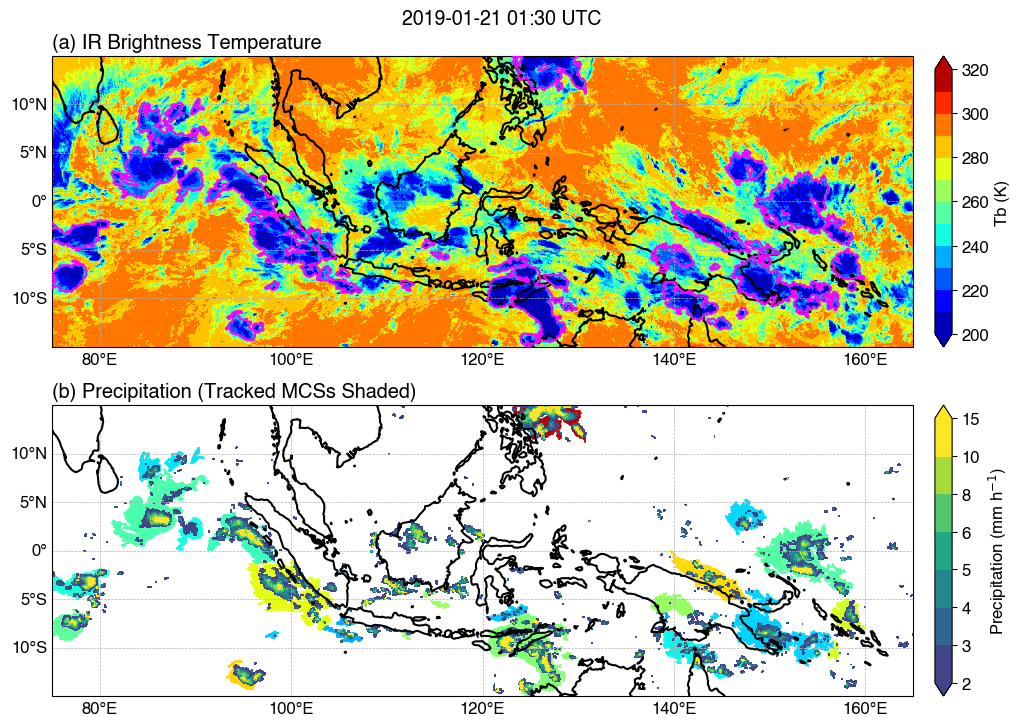

In [12]:
pcplev = [2,3,4,5,6,8,10,15]
tnlev = np.arange(ds.cloudtracknumber.min(), ds.cloudtracknumber.max(), 1)
levels = [np.arange(200, 320.1, 10), pcplev, tnlev]
cbticks = [np.arange(200, 320.1, 20), pcplev]
cblabels = ['Tb (K)', 'Precipitation (mm h$^{-1}$)']
cmap_tb = truncate_colormap(plt.get_cmap('jet'), minval=0.05, maxval=0.95)
cmap_pcp = truncate_colormap(plt.get_cmap('viridis'), minval=0.2, maxval=1.0)
cmap_mcs = truncate_colormap(plt.get_cmap('jet_r'), minval=0.05, maxval=0.95)
cmaps = [cmap_tb, cmap_pcp, cmap_mcs]
# cmaps = ['jet', 'Blues_r', 'jet']
titles = ['(a) IR Brightness Temperature','(b) Precipitation (Tracked MCSs Shaded)']

# Loop over each time
itime = 1
# for itime in range(0, ntimes):
dataarr = [ds.tb.isel(time=itime), ds.precipitation.isel(time=itime), ds.cloudtracknumber.isel(time=itime)]
fdatetime = pd.to_datetime(ds.time.isel(time=itime).values).strftime('%Y%m%d_%H%M')
timestr = pd.to_datetime(ds.time.isel(time=itime).values).strftime('%Y-%m-%d %H:%M UTC')
figname = f'{figdir}{fdatetime}.png'
print(timestr)
fig = plot_map_2panels(dataarr, levels, cmaps, titles, cblabels, cbticks, timestr, figname)

In [10]:
figdir

'/global/cscratch1/sd/feng045/waccem/mcs_region/asia/mcstracking_ccs4_4h/20190101_20191231/quicklooks/20190121_20190121/'

In [11]:
# pcplev = [2,3,4,5,6,8,10,15]
# # pcplev = [1,2,3,4,5,7,10,15]
# tnlev = np.arange(ds.cloudtracknumber.min(), ds.cloudtracknumber.max(), 1)
# levels = [np.arange(200, 320.1, 10), pcplev, tnlev]
# cbticks = [np.arange(200, 320.1, 20), pcplev]
# cblabels = ['Tb (K)', 'Precipitation (mm h$^{-1}$)']
# cmap_tb = truncate_colormap(plt.get_cmap('jet'), minval=0.05, maxval=0.95)
# cmap_pcp = truncate_colormap(plt.get_cmap('viridis'), minval=0.2, maxval=1.0)
# cmap_mcs = truncate_colormap(plt.get_cmap('jet_r'), minval=0.05, maxval=0.95)
# cmaps = [cmap_tb, cmap_pcp, cmap_mcs]
# # cmaps = ['jet', 'Blues_r', 'jet']
# titles = ['(a) IR Brightness Temperature','(b) Precipitation (Tracked MCSs Shaded)']

# # Loop over each time
# for itime in range(0, ntimes):
#     dataarr = [ds.tb.isel(time=itime), ds.precipitation.isel(time=itime), ds.cloudtracknumber.isel(time=itime)]
#     fdatetime = pd.to_datetime(ds.time.isel(time=itime).values).strftime('%Y%m%d_%H%M')
#     timestr = pd.to_datetime(ds.time.isel(time=itime).values).strftime('%Y-%m-%d %H:%M UTC')
#     figname = f'{figdir}{fdatetime}.png'
#     print(timestr)
#     fig = plot_map_2panels(dataarr, levels, cmaps, titles, cblabels, cbticks, timestr, figname)
#     plt.close(fig)